In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from datetime import datetime, timedelta
from fredapi import Fred
import quandl

In [3]:
def get_info(names):
    data = []
    for i in range(len(names)):
        data.append(fred.get_series(names[i]).to_frame().rename(columns={0:names[i]}))
        data[i] = data[i].groupby(data[i].index.year).mean().dropna()
    return data

In [4]:
# https://github.com/mortada/fredapi
fred = Fred(api_key="a02df0a22c57860f5f7cf25edc70ffb3")
quandl.ApiConfig.api_key = "QZLZXdHDDPZna9Yw48NP"

# West - California

Define the variables to be used in analysis:

X attributes:
 - *Monthly* Stocks
     * S&P 500 (MULTPL/SP500_REAL_PRICE_MONTH)
 - *Quarterly* Gross Domestic Product (GDP)
 - *Annual* Unemployment Rate (LAUST060000000000003A)
 - *Annual* House Ownership Ratio (CAHOWN)
 - *Annual* Resident Population (CAPOP)
 - *Annual* Median Income Rate (MEHOINUSCAA672N)
 - *Annual* Home Vacancy Rate (CAHVAC)

y attributes:

 - *Quarterly* California State Housing Price Index (CASTHPI)

Connect to APIs and create a dataframe with information from each dataset:

In [5]:
sp500 = quandl.get('MULTPL/SP500_REAL_PRICE_MONTH').rename(columns={'Value':'SP500'})
names_ca = ['LAUST060000000000003A', "CAHOWN","CAPOP", "MEHOINUSCAA672N", "CAHVAC",'GDPA']
sp500 = sp500.groupby(sp500.index.year).mean().dropna()
ca_data_series = get_info(names_ca) + [sp500]

In [6]:
# quarterly housing price index
caHPI = fred.get_series('CASTHPI').to_frame()
caHPI.index.name = "DATE"
caHPI = caHPI.rename(columns={0:"CASTHPI"})
# convert to annual
caHPI_annual = caHPI.groupby(caHPI.index.year).mean()

In [7]:
ca_annual = caHPI_annual.copy()
for df in ca_data_series:
    ca_annual = ca_annual.merge(df, left_index=True, right_index=True)
ca_annual.tail()

,CASTHPI,LAUST060000000000003A,CAHOWN,CAPOP,MEHOINUSCAA672N,CAHVAC,GDPA,SP500
2014,489.2725,7.5,54.2,38625.139,64221.0,1.1,17527.258,1930.667500
2015,524.2275,6.2,54.3,38953.142,67448.0,1.2,18224.780,2061.199167
2016,561.8125,5.5,53.8,39209.127,69729.0,1.0,18715.040,2091.844167
2017,605.3800,4.8,54.4,39399.349,71745.0,1.0,19519.424,2448.217500
2018,652.4350,4.2,55.1,39557.045,70489.0,1.2,20580.223,2744.680000


Analyze the correlation coefficient for each indicator we have specified:

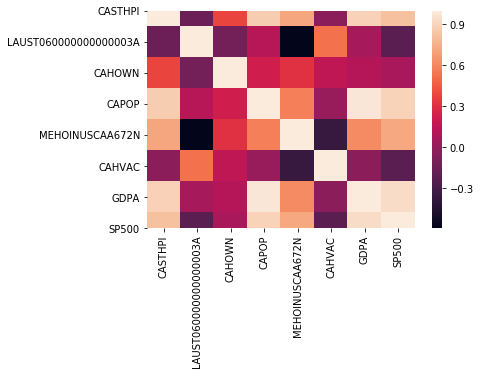

In [8]:
corr = ca_annual.corr().round(4)
sns.heatmap(data=corr)

In [9]:
corr

,CASTHPI,LAUST060000000000003A,CAHOWN,CAPOP,MEHOINUSCAA672N,CAHVAC,GDPA,SP500
CASTHPI,1.0000,-0.1523,0.3836,0.8695,0.7184,-0.0315,0.8896,0.8241
LAUST060000000000003A,-0.1523,1.0000,-0.1220,0.1263,-0.5935,0.5236,0.0619,-0.2165
CAHOWN,0.3836,-0.1220,1.0000,0.2278,0.3126,0.1589,0.1170,0.0675
CAPOP,0.8695,0.1263,0.2278,1.0000,0.5763,0.0111,0.9808,0.8965
MEHOINUSCAA672N,0.7184,-0.5935,0.3126,0.5763,1.0000,-0.3606,0.6178,0.7262
CAHVAC,-0.0315,0.5236,0.1589,0.0111,-0.3606,1.0000,-0.0357,-0.2154
GDPA,0.8896,0.0619,0.1170,0.9808,0.6178,-0.0357,1.0000,0.9316
SP500,0.8241,-0.2165,0.0675,0.8965,0.7262,-0.2154,0.9316,1.0000


In [10]:
Create a model using linear regression to express the Case-Schiller index as dependent on the other datasets we have downloaded:

SyntaxError: invalid syntax (<ipython-input-10-e7298399cefe>, line 1)

In [ ]:
X = ca_annual.drop(columns=['CASTHPI'], axis=1)
Y = ca_annual['CASTHPI']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)
lin_model = LinearRegression()
lin_model.fit(X_train, Y_train)

In [ ]:
# model evaluation for training set
y_train_predict = lin_model.predict(X_train)
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
r2 = r2_score(Y_train, y_train_predict)

print("The model performance for training set")
print("--------------------------------------")
print('Root Mean Squared Error is {}'.format(rmse))
print('R-Squared score is {}'.format(r2))
print("\n")

# model evaluation for testing set
y_test_predict = lin_model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
r2 = r2_score(Y_test, y_test_predict)

print("The model performance for testing set")
print("--------------------------------------")
print('Root Mean Squared Error is {}'.format(rmse))
print('R-Squared score is {}'.format(r2))